0.6931471805599453
[ 1.14201564  0.60123715  1.1671581  -1.87180902 -0.91567127 -1.26944015
  0.12678674 -0.36850105 -0.34494251 -0.17391076 -1.4237067  -0.04838577
 -0.60631733 -0.26916588 -1.16320191 -0.24269703 -0.20697485 -0.04305268
 -0.28008545 -0.28708932 -0.46912456 -1.03629766  0.02904379 -0.29250729
  0.01716376 -0.32880515 -0.13795624 -0.93187564]
El porcentaje de aciertos es 81.35593220338984 %


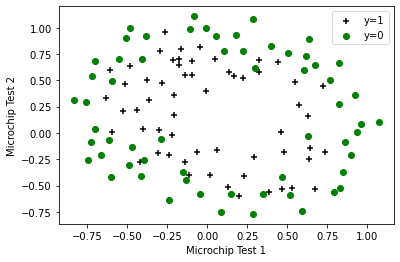

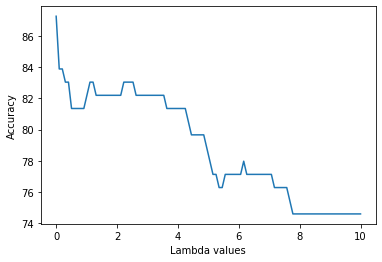

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures

def carga_csv(file_name):
    return read_csv(file_name, header=None).to_numpy().astype(float)

def apartado_1_1():
    
    data = carga_csv('ex2data1.csv')
    X = data[:, :-1]
    Y = data[:, -1]
    # Obtiene un vector con los índices de los ejemplos positivos
    pos = np.where(Y == 1 )
    neg = np.where(Y == 0)

    # Dibuja los ejemplos positivos
    plt.figure(0)
    plt.scatter(X[pos, 0],X[pos, 1], marker='+', c='k', label='Admitted')
    plt.scatter(X[neg, 0],X[neg, 1], marker='o', c='g', label='Not admitted')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend()
    plt.savefig('dataGraph1')

    return 0   

def sigmoide(target):
    target = 1 / ( 1 + np.exp(-target))
    return target

def apartado_1_2():

    print(sigmoide(5))
    print(sigmoide(np.arange(6)))
    print(sigmoide(np.matrix('0 1; 2 3; 4 5')))

    return 0

def gradiente(theta, X, Y):
    m = np.shape(X)[0]
    H = sigmoide(np.matmul(X, theta))
    return (np.matmul(X.T, H - Y)) / m

def coste(theta, X, Y):
    m = np.shape(X)[0]
    H = sigmoide(np.matmul(X, theta))
    return (np.dot(np.transpose(np.log(H)), Y) + np.dot(np.transpose(np.log(1-H)), (1-Y))) / -m    

def apartado_1_2():

    data = carga_csv('ex2data1.csv')
    X = data[:, :-1]
    Y = data[:, -1]
    m = np.shape(X)[0]
    X = np.hstack([np.ones([m,1]), X])
    n = np.shape(X)[1]
    theta = np.zeros(n)
    print(coste(theta, X, Y))
    print(gradiente(theta, X, Y))

    result = opt.fmin_tnc(func = coste, x0=theta, fprime=gradiente, args=(X,Y))
    theta_opt = result[0]
    print(coste(theta_opt, X, Y))

    # Dibuja los ejemplos positivos
    plt.figure(0)
    x1_min , x1_max = X[:, 1].min(), X[:, 1].max()
    x2_min , x2_max = X[:, 1].min(), X[:, 2].max()

    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

    h = sigmoide(np.c_[np.ones((xx1.ravel().shape[0], 1)),
                        xx1.ravel(),
                        xx2.ravel()].dot(theta_opt))
    h = h.reshape(xx1.shape)

    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')
    plt.savefig('dataGraph1line')
    plt.close()

    #Apartado 1.5
    prediccion = sigmoide(np.matmul(X, theta_opt))
    correctos = np.mean((prediccion>=0.5)==Y)
    print("El porcentaje de aciertos es " + str(correctos*100) + " %")

def apartado2():
    data = carga_csv('ex2data2.csv')
    X = data[:, :-1]
    Y = data[:, -1]
    # Obtiene un vector con los índices de los ejemplos positivos
    pos = np.where(Y == 1)
    neg = np.where(Y == 0)

    # Dibuja los ejemplos positivos
    plt.figure(0)
    plt.scatter(X[pos, 0], X[pos, 1], marker='+', c='k', label='y=1')
    plt.scatter(X[neg, 0], X[neg, 1], marker='o', c='g', label='y=0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.savefig('dataGraph2')

    # Apartado 2.1
    poly = PolynomialFeatures(6)
    Xp = poly.fit_transform(X)

    # Apartado 2.2
    thetas = np.zeros(np.shape(Xp)[1])
    costeR = costeReg(thetas, Xp, Y, 1)
    gradR = gradienteReg(thetas, Xp, Y, 1)
    print(costeR)

    # Apartado 2.3
    result = opt.fmin_tnc(func=costeReg, x0=thetas, fprime=gradienteReg, args=(Xp,Y,1))
    theta_opt = result[0]
    print(theta_opt)
    graficaLimite(Xp, Y, theta_opt, poly)
    
    prediccion = sigmoide(np.matmul(Xp, theta_opt))
    correctos = np.mean((prediccion>=0.5)==Y)
    print("El porcentaje de aciertos es " + str(correctos*100) + " %")

    # Apartado 2.4
    efectosReg(Xp, Y, thetas)
        
def efectosReg(Xp, Y, thetas):
    accuracy = []
    lambdas = np.linspace(0, 10, 100)
    for i in range(np.shape(lambdas)[0]):
        theta_opt = opt.fmin_tnc(func=costeReg, x0=thetas, fprime=gradienteReg, args=(Xp,Y,lambdas[i]))[0]
        accuracy.append(np.mean((sigmoide(np.matmul(Xp, theta_opt))>=0.5)==Y) * 100)
    
    plt.figure()
    plt.xlabel("Lambda values")
    plt.ylabel("Accuracy")
    plt.plot(lambdas, accuracy)
    plt.savefig("Regularization")

def costeReg(thetas, x, y, lamb):
    sigXT = sigmoide(np.matmul(x, thetas))
    return (-1/np.shape(x)[0]) * (np.matmul(np.transpose(np.log(sigXT)), y) + np.matmul(np.transpose(np.log(1-sigXT)), (1-y))) + ((lamb/(2*np.shape(x)[0])) * sum(thetas **2))

def gradienteReg(thetas, x, y, lamb):
    sigXT = sigmoide(np.matmul(x, thetas))
    return ((1/np.shape(x)[0]) * np.matmul(np.transpose(x), (sigXT - y))) + ((lamb/np.shape(x)[0]) * thetas)

def graficaLimite(X, Y, theta, poly):
    plt.figure()
    pos = np.where(Y == 1)
    neg = np.where(Y == 0)

    x1_min, x1_max = X[:, 1].min(), X[:, 1].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 2].max()

    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

    h = sigmoide(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(theta))

    h = h.reshape(xx1.shape)

    plt.scatter(X[pos, 1], X[pos, 2], marker="+", c="k", label="y=1")
    plt.scatter(X[neg, 1], X[neg, 2], marker="o", c="lightgreen", label="y=0")
    plt.legend()
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')

    plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='g')
    plt.savefig('dataGraph2limit')
    plt.close()

#apartado_1_1()
#apartado_1_2()
apartado2()
